In [1]:
import numpy as np
import pandas as pd
import matplotlib.ticker as tick
import matplotlib.pyplot as plt

In [2]:
# Import data
data_path = '../data/'
estimated_file = data_path+'combined/processConversionFactors_w_uncertainties.csv'
production_file = data_path+'/processed/icisFacilityProduction.csv'

#colors = ['#E69973', '#CEE675', '#E56181', '#49E6DA', '#B455E6']
colors = ['#E66070', '#E6A730', '#6EE588', '#498DE6', '#A055E6']

In [3]:
# Emissions
emissions = pd.read_csv(estimated_file)

# Production
production = pd.read_csv(production_file, index_col=0)
year = '2049'

In [4]:
yearly_prod = production[['PRODUCT',year]].groupby('PRODUCT').sum().reset_index()

ifa_prod = pd.read_csv(data_path+'extracted/IFA_production_w_uncertainties.csv')[['PRODUCT', year]].groupby('PRODUCT').sum().reset_index()

name_conversions = {
    'NH3': 'AMMONIA',
    'AN': 'AMMONIUM NITRATE',
    'Ammonium nitrate (33.5-0-0) granulated': 'AMMONIUM NITRATE',
    'AS': 'AMMONIUM SULPHATE',
    'CAN': 'CALCIUM AMMONIUM NITRATE',
    'Calcium ammonium nitrate (27-0-0)': 'CALCIUM AMMONIUM NITRATE',
    'Urea (46-0-0)': 'UREA'
}

ifa_prod['PRODUCT'] = ifa_prod['PRODUCT'].replace(name_conversions)

total_prod = pd.concat((yearly_prod, ifa_prod)).sort_values('PRODUCT').reset_index(drop=True)

In [5]:
data = pd.read_parquet('C:/Users\lukec\OneDrive - University of Cambridge\PhD\Power_BI\input_data/country_summaries_unpivoted.parquet')

In [6]:
## Get intermediates factors

def filter_df(df, cols, filters):
    for col, filt in zip(cols, filters):
        df = df[[i in filt for i in df[col]]]
    return df

data_filt = filter_df(data, ['Gas', 'Type', 'Year', 'Region', 'Product type'], [['CO2e_100a'], ['Direct Process', 'Feedstock', 'Direct Energy Use', 'Indirect Energy Use', 'Primary chemicals', 'Organic chemicals', 'Other intermediates'], [int(year)], ['World'], ['Intermediates']])

factors = data_filt.pivot(index=['Region', 'COUNTRY/TERRITORY', 'Product group', 'PRODUCT', 'Gas', 'Product type', 'Year'], columns='Type', values=['sigma_y', 'y'])

intermediate_groups = ['Primary chemicals', 'Organic chemicals', 'Other intermediates']
source_groups = ['Direct Process', 'Feedstock', 'Direct Energy Use', 'Indirect Energy Use']

subset = data_filt.groupby(['Product group', 'Type']).sum().reset_index()
subset = filter_df(subset, ['Product group', 'Type'], [intermediate_groups, source_groups])
totals = subset.groupby('Product group').sum().reset_index()
subset = subset.merge(totals, on='Product group')
subset['ratio'] = subset['y_x']/subset['y_y']
pg_source_ratios = subset[['Product group', 'Type', 'ratio']].set_index(['Product group', 'Type'])

factors_acc = factors.copy()
for col in intermediate_groups:
    col_vals = factors_acc[('y', col)]
    for source in source_groups:
        factors_acc[('y', source)] = factors_acc[('y', source)]+factors_acc[('y', col)]*pg_source_ratios.loc[(col, source)].values[0]

In [7]:
## Get downstream factors

data_filt_ds = filter_df(data, ['Gas', 'Type', 'Year', 'Region', 'Product type'], [['CO2e_100a'], ['Direct Process', 'Feedstock', 'Direct Energy Use', 'Indirect Energy Use', 'Primary chemicals', 'Organic chemicals', 'Other intermediates'], [int(year)], ['World'], ['Downstream']])

factors_ds = data_filt_ds.pivot(index=['Region', 'COUNTRY/TERRITORY', 'Product group', 'PRODUCT', 'Gas', 'Product type', 'Year'], columns='Type', values=['sigma_y', 'y'])

source_groups = ['Direct Process', 'Feedstock', 'Direct Energy Use', 'Indirect Energy Use']+['Primary chemicals', 'Organic chemicals', 'Other intermediates']

subset = data_filt_ds.groupby(['Product group', 'Type']).sum().reset_index()
subset = filter_df(subset, ['Type'], [source_groups])
totals = subset.groupby('Product group').sum().reset_index()
subset = subset.merge(totals, on='Product group')
subset['ratio'] = subset['y_x']/subset['y_y']
pg_source_ratios = subset[['Product group', 'Type', 'ratio']].set_index(['Product group', 'Type'])

factors_ds_acc = factors_ds.copy()
# for col in source_groups:
#     col_vals = factors_ds_acc[('y', col)]
# for source in source_groups:
#     factors_ds_acc[('y', source)] = factors_ds_acc[('y', source)]+factors_ds_acc[('y', col)]*pg_source_ratios.loc[(col, source)].values[0]

In [8]:
def create_groupings(factors, type='y', columns=None):

    if columns is None:
        columns = ['Direct Process', 'Feedstock', 'Direct Energy Use', 'Indirect Energy Use']

    used_emissions = factors[type].reset_index().groupby(['Product type', 'Product group', 'PRODUCT']).sum().reset_index().drop(columns=['Year'])
    used_emissions = used_emissions.merge(total_prod, on='PRODUCT', how='left')

    prod_grouping = used_emissions.copy()
    prod_grouping['Total_val'] = np.sum(used_emissions[columns], axis=1)

    for col in columns:
        prod_grouping[col] = prod_grouping[col]/prod_grouping[year]
    prod_grouping['Total_factor'] = np.sum(prod_grouping[columns], axis=1)

    type_grouping = used_emissions.groupby(['Product type', 'Product group']).sum().reset_index()
    type_grouping['Total_val'] = np.sum(type_grouping[columns], axis=1)
    for col in columns:
        type_grouping[col] = type_grouping[col]/type_grouping[year]
    type_grouping['Total_factor'] = np.sum(type_grouping[columns], axis=1)

    return prod_grouping, type_grouping

In [9]:
def plot_boxes(df, columns, colors, plot_col='Product group', err=True, scale_factor=1/1000, unit='Mt', firstword=False,
               ylabel1='Unit CO$_{2e}$ emissions ', ylabel2='CO$_{2e}$ emissions', plot_bars=True):
    index = range(len(df))
    plt.rcParams.update({'font.size':fontsize})

    values = [df[col] for col in columns]
    labels = columns #['Direct Process', 'Feedstock', 'Direct Energy Use', 'Indirect Energy Use']
    #colors = ['C1', 'C2', 'c', 'C4', 'C5', 'C6', 'C7']

    if plot_bars:
        ax2 = ax.twinx()

    for enum, (y, z, c) in enumerate(zip(values, labels, colors)):
        pos_bottom = np.sum(np.array(values[:enum]).clip(0), axis=0) if enum > 0 else None
        neg_bottom = np.sum(np.array(values[:enum]).clip(max=0), axis=0) if enum > 0 else None
        bottom = [pos_bottom[num] if val>=0 else neg_bottom[num] for num, val in enumerate(y)] if enum > 0 else None
        p1 = ax.bar(df['Centres']*scale_factor, y, width=df[year]*scale_factor, bottom=bottom, label=z, color=c, alpha=0.96, edgecolor='k')

        ax.xaxis.set_major_formatter(tick.StrMethodFormatter('{x:,.0f}'))

        if plot_bars:
            if err:
                p2 = ax2.errorbar(df['Centres']*scale_factor, df['Total_val_x']*scale_factor, yerr=df['Total_val_y']*scale_factor, fmt='o', color='b', ecolor='k', capsize=5, label='Total')
            else:
                p2 = ax2.scatter(df['Centres']*scale_factor, df['Total_val']*scale_factor, color='b', marker='o', edgecolors='k', label='Absolute uncertainty')
                p2 = ax.scatter(1, 1, color='b', marker='o', edgecolors='k', label='Absolute uncertainty')
                # for i, label in enumerate(df['Total_val']*scale_factor):
                #     ax2.annotate(label, ((df['Centres']*scale_factor)[i], (df['Total_val']*scale_factor)[i]), textcoords="offset points", xytext=(0,10), ha='center')
            ax2.tick_params(axis='y', labelcolor='blue', color='blue')
            ax2.spines['right'].set_color('blue')
            ax2.set_ylim(bottom=0)
            ax2.set_ylabel(ylabel2+' ('+unit+')', color='b')
            ax2.grid(axis='y', linestyle='dashed', zorder=0)
        else: ax.grid(axis='y', linestyle='dashed', zorder=0)
        #ax2.yaxis.set_major_formatter(tick.StrMethodFormatter('{x:,.0f}'))

        # ps = p1+p2
        # labs = [p.get_label() for p in ps]
        # ax.legend(ps, labs)

        if z==labels[-1]:
            if firstword:
                ax.bar_label(p1, labels= [i.split(' ')[0] for i in df[plot_col]], rotation=0)
            else: ax.bar_label(p1, labels= [i[:2] for i in df[plot_col]], rotation=0)

    ax.set_xlabel('Product Output ('+unit+')')
    ax.set_ylabel(ylabel1+'\n(kg CO$_{2e}$/kg)')
    return ax

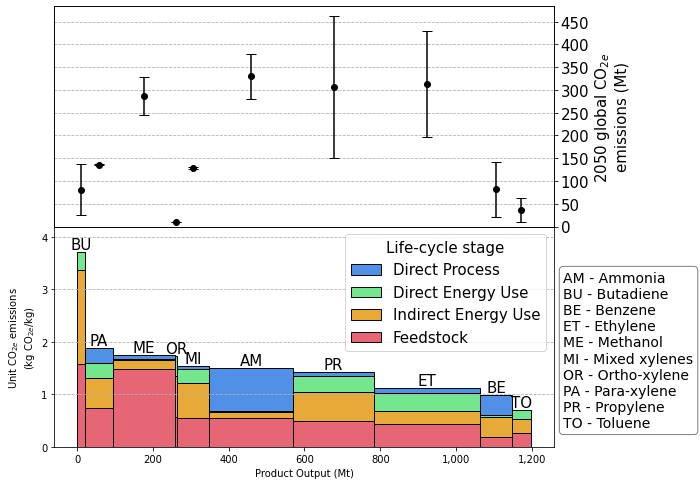

In [10]:
import matplotlib.ticker as ticker
## Create production values figure
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': [1, 1]}, figsize=[10,7], facecolor='white')

width=0.7
fontsize=15

columns = ['Feedstock', 'Indirect Energy Use', 'Direct Energy Use', 'Direct Process']
used_prods = ['AMMONIA', 'BUTADIENE', 'BENZENE', 'ETHYLENE', 'METHANOL', 'PROPYLENE', 'TOLUENE', 'MIXED XYLENES', 'ORTHO-XYLENE', 'PARA-XYLENE']

prod_grouping, type_grouping = create_groupings(factors_acc, 'y')
prod_grouping_s, type_grouping_s = create_groupings(factors_acc, 'sigma_y')
prod_grouping = prod_grouping.merge(prod_grouping_s[['PRODUCT', 'Total_val', 'Total_factor']], on='PRODUCT')

individual_prods = filter_df(prod_grouping, ['PRODUCT'], [used_prods]).sort_values('Total_factor_x', ascending=False)
individual_prods['Cml'] = individual_prods[year].cumsum()
individual_prods['Centres'] = individual_prods['Cml']-individual_prods[year]/2

ax = axs[1]
ax = plot_boxes(individual_prods, columns, colors=colors, plot_col='PRODUCT', plot_bars=False)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Life-cycle stage', bbox_to_anchor=[1, 1])
ax.text(1.02, 0.8, 'AM - Ammonia\nBU - Butadiene\nBE - Benzene\nET - Ethylene\nME - Methanol\nMI - Mixed xylenes\nOR - Ortho-xylene\nPA - Para-xylene\nPR - Propylene\nTO - Toluene', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox={'boxstyle':'round', 'linestyle':'-', 'facecolor':'w', 'alpha':0.5})
ax.set_ylim([0,4.2])

ax2 = axs[0].twinx()

df = individual_prods.copy()
scale_factor=1/1000
unit='Mt'
ylabel2='2050 global CO$_{2e}$\nemissions'
p2 = ax2.errorbar(df['Centres']*scale_factor, df['Total_val_x']*scale_factor, yerr=df['Total_val_y']*scale_factor, fmt='o', color='k', ecolor='k', capsize=5, label='Total')
#ax2.tick_params(axis='y', labelcolor='blue', color='blue')
#ax2.spines['right'].set_color('blue')
ax2.set_ylim(bottom=0)
ax2.set_ylabel(ylabel2+' ('+unit+')')
ax2.grid(axis='y', linestyle='dashed', zorder=0)
axs[0].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(50))

fig.tight_layout()